In [1]:
%pip install segmentation-models-pytorch
%pip install pytorch-lightning 
%pip install wandb -qU
%pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=0b0321e2fb36648c512581eb792e950c81bb8c45ead41e2ae0f9ad11e0317f91
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=628204131acca145fc01bbd784c2409f7f2d44be05c0a888f2f37eb5a7a6b699
  Stored in directory: /root/.cache/pip/w

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torchvision import models
from PIL import Image, ImageDraw,ImageOps
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp


import torch
import pandas as pd
import numpy as np
import os
import cv2


import warnings
warnings.filterwarnings('ignore')

import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
import wandb

In [4]:
torch.cuda.is_available()

True

# Model Setup

In [5]:
N_EPOCH=100
ENCODER = 'resnet18'
Frozen_Encoder_Flag=True
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['nail']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation


LEARNING_RATE=3.4e-4
BATCH_SIZE=15
LOSS_TYPE='DiceLoss'
MODEL_SAVE_NAME="Unet_resnet18_"
DATASET="inat_raw_data_train327_val115:v0"




   
config={ #model
        "architecture": "Unet",
        "encoder":ENCODER,
        "frozen_encoder":Frozen_Encoder_Flag,
        "encoder_weights":ENCODER_WEIGHTS,
        "classes":CLASSES,
        "activation":ACTIVATION,
        # loss
        "loss":"DiceLoss",
        "metrics":"IoU",
        #optimiser
        "learning_rate": LEARNING_RATE,
        #dataset
        "dataset": DATASET,
        # calculation details
        "epochs": N_EPOCH,}

run=wandb.init(project="Card_detection",
           notes="wandb setup",
           config=config,
           tags=ENCODER)




<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Get Data

In [6]:
# dowload data from the wandb
artifact = run.use_artifact('team-invonto/Card_detection/inat_data_train63_val115:v0', type='raw_data')
artifact.download('/tmp/')

import zipfile

def load_data_to_tmp(folder_name):
  zip_ref = zipfile.ZipFile('/tmp/'+folder_name, 'r') #Opens the zip file in read mode
  zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
  zip_ref.close()

load_data_to_tmp('Train.zip')
load_data_to_tmp('Validation.zip')

wandb:   2 of 2 files downloaded.  


# Dataset


In [7]:
class CardDataset(Dataset):
    """NailDataset dataset.
    img generator that take file names and selected poligons from csv_file
    """

    def __init__(self, csv_file, root_dir, transform=None, augmentation=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
                
            nail_dataset[img_number_in_csv][1] -image
            nail_dataset[img_number_in_csv][0] -corresponding mask image 
        """
        self.nail_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return self.nail_frame.shape[0]

    def __getitem__(self, idx):
        file_id=self.nail_frame.iloc[idx]["filename"]
        #"read image"
        img_name = os.path.join(self.root_dir,self.nail_frame.iloc[idx]["filename"])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask_name=os.path.join(self.root_dir,self.nail_frame.iloc[idx]["mask"])
        mask = cv2.imread(mask_name)
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)

            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            image = self.transform['image'](image)
            mask = self.transform['mask'](mask)
    
         
        return image, mask

    
transform_dict = {'image': transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize(mean=[0.5815, 0.5152, 0.4708],
                              std=[0.2582, 0.2503, 0.2452]),]),
                 'mask': transforms.Compose([transforms.ToTensor()])}

# Data loader

In [8]:
n_cpu = os.cpu_count()
print("n_cpu={}".format(n_cpu))


#train
data_path='/tmp/'
x_train_path=os.path.join(data_path,'Train')
y_train_dataloader=os.path.join(x_train_path,'Train_DataLoader.csv')
train_dataset = CardDataset(y_train_dataloader, x_train_path,transform=transform_dict, augmentation=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,num_workers=n_cpu)
print('Number of training samples:', len(train_dataset))

# validation
x_valid_path = os.path.join(data_path, 'Validation/')
y_valid_dataloader = os.path.join(x_valid_path, 'Validation_DataLoader.csv')
valid_dataset = CardDataset(y_valid_dataloader,x_valid_path,transform=transform_dict, augmentation=None)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=n_cpu)
valid_dataset_vis=CardDataset(y_valid_dataloader, x_valid_path)
print('Number of validation samples:', len(valid_dataset))

n_cpu=2
Number of training samples: 63
Number of validation samples: 115


In [9]:
# image,mask=valid_dataset[0]
# plt.imshow(mask.numpy().transpose(1, 2, 0))

# # single batch
# batch_img=next(iter(valid_loader))[0]
# batch_mask=next(iter(valid_loader))[1]
# print(batch_img.shape)
# print(batch_mask.shape)

# Model U-Net
https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

In [10]:
class CardModel(pl.LightningModule):

    def __init__(self,arch,encoder_name,encoder_weights,learning_rate,frozen_encoder=True):
        super().__init__()
        self.lr=learning_rate
        self.save_hyperparameters()
        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.model = smp.create_model(
            arch, 
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=1,
            #activation='sigmoid'
            )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE,from_logits=True)
        
        if frozen_encoder==True:
            for child in self.model.encoder.children():
                for param in child.parameters():
                    param.requires_grad = False 
                    
                    
    def forward(self, image):
        mask = self.model(image)
        return mask
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)
        
        pred_mask=(output_mask.sigmoid() >= 0.5).float()
        
        

        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        train_batch_dictionary={"tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}
        
        self.training_step_outputs.append(train_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_train_epoch_end(self):
        # aggregate step metics
        outputs=self.training_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image) 
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "train_per_image_iou": per_image_iou,
        #    "train_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.training_step_outputs.clear() 



    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)
        
        pred_mask=(output_mask.sigmoid() >= 0.5).float()
        

        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        validation_batch_dictionary={"loss":loss,
                          "tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}
        
        self.validation_step_outputs.append(validation_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    

    def on_validation_epoch_end(self):
        # aggregate step metics
        outputs= self.validation_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image) 
        #dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "validation_per_image_iou": per_image_iou,
            #"validation_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.validation_step_outputs.clear()


    # def test_step(self, batch, batch_idx):
    #     image=batch[0]
    #     mask=batch[1]
    #     output_mask = self.forward(image)
    #     loss=self.loss_fn(output_mask,mask)
    #     pred_mask=(output_mask.sigmoid() >= 0.5).float()
    #     self.log("test/loss_epoch", loss, on_step=False, on_epoch=True)
        
    # def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
    #     torch.save(model.state_dict(),"PATH")
    #     dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
    #     model_filename = "model_final.onnx"
    #     self.to_onnx(model_filename, dummy_input, export_params=True)
    #     artifact = wandb.Artifact(name="model.ckpt", type="model")
    #     artifact.add_file(model_filename)
    #     wandb.log_artifact(artifact)


    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr or self.learning_rate))

    
    


In [11]:
card_model = CardModel("Unet", ENCODER,ENCODER_WEIGHTS,LEARNING_RATE,frozen_encoder=Frozen_Encoder_Flag)
ModelSummary(card_model,max_depth=1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 14.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
3.2 M     Trainable params
11.2 M    Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)

In [12]:
card_model = CardModel("Unet", "resnet34","imagenet",0.05,frozen_encoder=True)


wandb_logger = WandbLogger(project="Card_detection")
trainer = pl.Trainer(max_epochs=N_EPOCH,
                     logger=wandb_logger,
                     log_every_n_steps=1,
                     default_root_dir="/content/drive/MyDrive/Dataset/")
trainer.fit(
    model=card_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,)
    


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 239MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
3.2 M     Trainable params
21.3 M    Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [15]:
! pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


In [13]:
trainer.save_checkpoint("/content/drive/MyDrive/Dataset/card_model.ckpt")
wandb.save("/content/drive/MyDrive/Dataset/card_model.ckpt")

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/wandb/run-20230525_175208-fbgu8cm5/files/card_model.ckpt']

In [27]:
name="CardModel_UnetResNet18"
path = "/content/drive/MyDrive/Dataset/"
model_name=path+name+'.onnx'
torch.onnx.export(card_model,
                  torch.randn(1,3,480,320).to('cpu'),
                  model_name,
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'])
#wandb.save(model_name)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



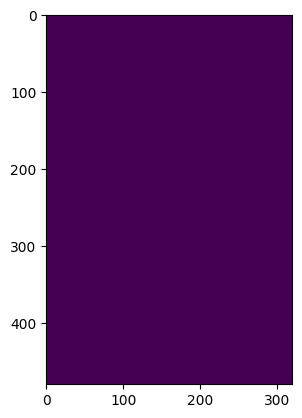

In [36]:
plt.imshow(outputs[0].squeeze().squeeze())

In [21]:
# save_path=("/content/drive/MyDrive/Dataset/card_model.ts")
# script=card_model.to_torchscript()
# torch.jit.save(script,save_path)
# wandb.save(save_path)

In [22]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_per_image_iou,▁▇▇▇███▇████████████████████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_per_image_iou,▁▂▅▆▇███████████████████████████████████
epoch,99
train_loss_epoch,0.00393
train_loss_step,0.00381
train_per_image_iou,0.99143


In [ ]:
# turn learning rate
# trainer = pl.Trainer(enable_progress_bar=True)
# tuner =pl.tuner.Tuner(trainer)
# lr_finder=tuner.lr_find(card_model,train_loader,mode='exponential',min_lr=1e-5, max_lr=0.1, num_training=20)
# print(lr_finder.results)



# fig = lr_finder.plot(suggest=True)
# suggested_lr = lr_finder.suggestion()
# print("suggested_lr",suggested_lr)
# fig.show()

# save data frame
# pd.DataFrame(lr_finder.results).to_csv("LR_tuning_1e-5_1_exponential.csv")

In [ ]:
model = card_model.load_from_checkpoint("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt")

# disable randomness, dropout, etc...
model.eval()
x=torch.zeros((1,3,480,320))
y_hat=model(x)


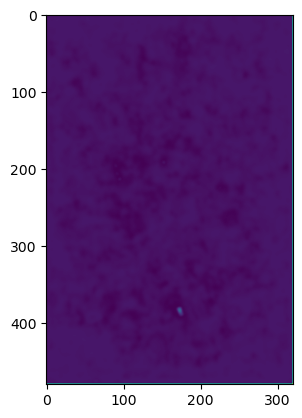

In [ ]:
model = card_model.load_from_checkpoint("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt")
model.eval()
x = torch.randn((1,3,480,320))

with torch.no_grad():
    y_hat = model(x)
    plt.imshow(y_hat.numpy().squeeze())

In [ ]:
y_hat.detach().numpy().shape

(1, 1, 480, 320)

In [ ]:
checkpoint = torch.load("/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/version_45/checkpoints/epoch=851-step=852.ckpt", map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])

In [ ]:
#tensorboard --logdir=/home/tatyana/Work_Invonto/Segmentation_PyTorch/Cards_Model/card_data_set/lightning_logs/